# Drug Resistance Heatmap
Author: Jonn Smith

This notebook creates a table and a plot indicating drug resistance for samples in this workspace.  The drug resistance determination is based on the MalariaGEN methods found [here](https://www.malariagen.net/sites/default/files/File6_Pf_6_resistance_classification.pdf).

In [21]:
# Standard set of imports:
import os

import numpy as np
import pandas as pd
import firecloud.api as fapi

from io import StringIO

from IPython.core.display import HTML

from google.cloud import storage
my_storage_client = storage.Client()

from tqdm.notebook import tqdm

In [22]:
# Define some helpers to use to load data from our workspace:
def load_table(namespace, workspace, root_entity_type):
    ent = fapi.get_entities(namespace, workspace, root_entity_type).json()
    tbl = pd.DataFrame(list(map(lambda e: e['attributes'], ent)))
    tbl[f"entity:{root_entity_type}_id"] = list(map(lambda f: f['name'], ent))

    return tbl

bucket = os.environ['WORKSPACE_BUCKET']       
workspace = os.environ['WORKSPACE_NAME']      
namespace = os.environ['WORKSPACE_NAMESPACE']

In [23]:
# Get our table of sample-level data and subset it to those samples that have drug resistance reports:
tbl = load_table(namespace, workspace, 'sample_set') 
reportable_samples = tbl.dropna(subset=["drug_res_report"])

In [24]:
# Set up some functions to determine drug sensitivity:

import re
from enum import Enum

pchange_regex = re.compile(r"""p\.([A-z]+)([0-9]+)([A-z]+)""")
AA_3_2 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K', 'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

DrugSensitivity = Enum("DrugSensitivity", ["UNDETERMINED", "SENSITIVE", "RESISTANT"])

def parse_pchange(pchange):
    old, pos, new = pchange_regex.match(pchange).groups()
    return AA_3_2[old.upper()], int(pos), AA_3_2[new.upper()]

def get_chloroquine_sensitivity(dr_report):
# Locus utilized: PF3D7_0709000 (crt)
# Codon: 76
# Workflow:
# Step Genetic change Interpretation Classification
# 1 76 K/T heterozygote Heterozygous mutant Undetermined
# 2 76 missing Missing Undetermined
# 3 K76 Wild type Sensitive
# 4 76T Mutant Resistant
# 5 otherwise Unknown mutant Undetermined

    for line in StringIO(dr_report):
        # We only care about this locus for this drug:
        if line.startswith("pfcrt PF3D7_0709000"):
            gene, locus, pchange, marker = line.strip().split(" ")
            old, pos, new = parse_pchange(pchange)
            if pos == 76:
                if (old == "L") and (new == "T") and (marker == "absent"):
                    return DrugSensitivity.SENSITIVE
                elif (new == "T") and (marker == "present"):
                    return DrugSensitivity.RESISTANT
                
    return DrugSensitivity.UNDETERMINED
                
def get_pyrimethamine_sensitivity(dr_report):
# Locus utilized: PF3D7_0417200 (dhfr)
# Codon: 108
# Workflow:
# Step Genetic change Interpretation Classification
# 1 108 S/N heterozygote Heterozygous mutant Undetermined
# 2 108 missing Missing Undetermined
# 3 S108 Wild type Sensitive
# 4 108N Mutant Resistant
# 5 otherwise Unknown mutant Undetermined

    for line in StringIO(dr_report):
        # We only care about this locus for this drug:
        if line.startswith("pfdhfr PF3D7_0417200"):
            gene, locus, pchange, marker = line.strip().split(" ")
            old, pos, new = parse_pchange(pchange)
            if pos == 108:
                if (old == "S") and (new == "N") and (marker == "absent"):
                    return DrugSensitivity.SENSITIVE
                elif (old == "S") and (new == "N") and (marker == "present"):
                    return DrugSensitivity.RESISTANT
                elif (new == "N") and (marker == "present"):
                    return DrugSensitivity.RESISTANT
                elif marker == "absent":
                    return DrugSensitivity.SENSITIVE
                
    return DrugSensitivity.UNDETERMINED


def get_sulfadoxine_sensitivity(dr_report):
# Locus utilized: PF3D7_0810800 (dhps)
# Codon: 437
# Workflow:
# Step Genetic change Interpretation Classification
# 1 437 A/G heterozygote Heterozygous mutant Undetermined
# 2 437 missing Missing Undetermined
# 3 A437 Wild type Sensitive
# 4 437G Mutant Resistant
# 5 otherwise Unknown mutant Undetermined

    for line in StringIO(dr_report):
        # We only care about this locus for this drug:
        if line.startswith("pfdhps PF3D7_0810800"):
            gene, locus, pchange, marker = line.strip().split(" ")
            old, pos, new = parse_pchange(pchange)
            if pos == 437:
                if (old == "A") and (new == "G") and (marker == "absent"):
                    return DrugSensitivity.SENSITIVE
                elif (old == "A") and (new == "G") and (marker == "present"):
                    return DrugSensitivity.RESISTANT
                elif (new == "G") and (marker == "present"):
                    return DrugSensitivity.RESISTANT
                elif marker == "absent":
                    return DrugSensitivity.SENSITIVE
                
    return DrugSensitivity.UNDETERMINED

def get_mefloquine_sensitivity(dr_report):
# Locus utilized: PF3D7_0523000 (mdr1)
# Codons: Amplification status of whole gene
# Workflow:
# Step Genetic change Interpretation Classification
# 1 Missing Missing Undetermined
# 2 Heterozygous duplication Heterozygous mutant Undetermined
# 3 Single copy Wild type Sensitive
# 4 Multiple copies Mutant Resistant

    # Currently we can't determine this.
    # We need to get CNV calling working first.
                
    return DrugSensitivity.UNDETERMINED

def get_artemisinin_sensitivity(dr_report):
# Locus utilized: PF3D7_1343700 (kelch13)
# Codons: 349-726 (BTB/POZ and propeller domains)
# Workflow:
# Step Genetic change Interpretation Classification
# 1 Homozygous non-synonymous mutations in the kelch13 BTB/POZ and propeller
# domain classified by the World Health Organisation as associated with delayed
# parasite clearance 
# Mutant – associated with delayed clearance Resistant
# 2 Heterozygous non-synonymous mutations in the kelch13 BTB/POZ and
# propeller domain classified by the World Health Organisation as associated
# with delayed parasite clearance
# Mutant - heterozygous Undetermined
# 3 578S as homozygous Mutant - not associated Sensitive
# 4 Any missing call in amino acids 349-726 Missing Undetermined
# 5 No non-reference calls in amino acids 349-726 Wild-type Sensitive
# 6 otherwise Mutant - not in WHO list Undetermined

    for line in StringIO(dr_report):
        # We only care about this locus for this drug:
        if line.startswith("pfkelch13 PF3D7_1343700"):
            gene, locus, pchange, marker = line.strip().split(" ")
            old, pos, new = parse_pchange(pchange)
            
            has_non_ref = False
            has_variants = False
            if 349 <= pos <= 726:
                if (old != new) and (marker == "present"):
                    return DrugSensitivity.RESISTANT
                elif (new == "S") and (marker == "present"):
                    return DrugSensitivity.SENSITIVE
                elif marker == "present":
                    has_non_ref = True
                has_variants = True
    if (has_variants) and (not has_non_ref):
        return DrugSensitivity.SENSITIVE
    
    return DrugSensitivity.UNDETERMINED

def get_piperaquine_sensitivity(dr_report):
# Loci utilized: PF3D7_1408000 (plasmepsin 2) and PF3D7_1408100 (plasmepsin 3)
# Codons: Amplification status of both genes
# Workflow:
# Step Genetic change Interpretation Classification
# 1 Missing Missing Undetermined
# 2 Heterozygous duplication Heterozygous mutant Undetermined
# 3 Single copy Wild type Sensitive
# 4 Multiple copies Mutant Resistant

    # Currently we can't determine this.
    # We need to get CNV calling working first.
                
    return DrugSensitivity.UNDETERMINED

In [25]:
def get_drug_resistance_names():
    return "Chloroquine", "Pyrimethamine", "Sulfadoxine", "Mefloquine", "Artemisinin", "Piperaquine"

def get_drug_resistance(sample_id, sample_df, do_print=True):
    # Get the GSURI to the drug resistance report:
    row = reportable_samples.loc[reportable_samples["entity:sample_set_id"] == sample_id]
    dr_report_gs_url = row.iloc[0]["drug_res_report"]

    blob = storage.Blob.from_string(dr_report_gs_url)
    
    # Download the file contents:
    dr_report_contents = blob.download_as_text(client=my_storage_client)

    chloroquine = get_chloroquine_sensitivity(dr_report_contents)
    pyrimethamine = get_pyrimethamine_sensitivity(dr_report_contents)
    sulfadoxine = get_sulfadoxine_sensitivity(dr_report_contents)
    mefloquine = get_mefloquine_sensitivity(dr_report_contents)
    artemisinin = get_artemisinin_sensitivity(dr_report_contents)
    piperaquine = get_piperaquine_sensitivity(dr_report_contents)

    if do_print:
        print("Sample\t" + "\t".join(get_drug_resistance_names()))
        print(f"{sample_id}\t", end='')
        for r in [chloroquine, pyrimethamine, sulfadoxine, mefloquine, artemisinin, piperaquine]:
            print(f"{r.name}\t", end='')
        print()
        
    return chloroquine, pyrimethamine, sulfadoxine, mefloquine, artemisinin, piperaquine

***
## Plot the Drug Resistance of some of the Samples

In [26]:
def create_resistance_matrix(reportable_samples):
    # Generate the resistance matrix:
    sample_ids = sorted(reportable_samples["entity:sample_set_id"])
    resistance_matrix = np.zeros((len(sample_ids), 6), int)  # We have 6 drugs to test for.

    for i, sample_id in tqdm(enumerate(sample_ids), desc="Computing drug resistances", total=len(sample_ids)):
        resistances = get_drug_resistance(sample_id, reportable_samples, do_print=False)
        resistance_matrix[i, :] = [r.value for r in resistances]
    
    return sample_ids, resistance_matrix

# Generate the resistance matrix:
sample_ids, resistance_matrix = create_resistance_matrix(reportable_samples)

Computing drug resistances:   0%|          | 0/1382 [00:00<?, ?it/s]

In [27]:
# Define plotting helper functions / settings:

import matplotlib
import matplotlib.pyplot as plt

gFIG_SIZE_in = [14, 10]

# Set plotting defaults:
gPLOT_PARAMS = {
    "legend.fontsize": "x-large",
    "figure.figsize": gFIG_SIZE_in,
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large"
}
matplotlib.rcParams.update(gPLOT_PARAMS)
plt.rcParams.update(gPLOT_PARAMS)

# Some single-place definitions of sizes for plots / figures:
gFONT_SIZE_UNITS = "pt"
gTITLE_FONT_SIZE = 36
gAXIS_LABEL_FONT_SIZE = 24
gTICK_LABEL_FONT_SIZE = 16
gTEXT_FONT_SIZE = 16

def fix_plot_visuals(fig,
                     titlesize=gTITLE_FONT_SIZE,
                     labelsize=gAXIS_LABEL_FONT_SIZE,
                     ticklabelsize=gTICK_LABEL_FONT_SIZE,
                     textsize=gTEXT_FONT_SIZE,
                     tight_rect=None):
    """Fix the plot elements to be appropriate sizes for a slide / presentation."""

    if not textsize:
        textsize = ticklabelsize

    for ax in fig.get_axes():

        for ticklabel in (ax.get_xticklabels()):
            ticklabel.set_fontsize(ticklabelsize)
        for ticklabel in (ax.get_yticklabels()):
            ticklabel.set_fontsize(ticklabelsize)
        for c in ax.get_children():
            if c.__class__ == matplotlib.text.Text:
                c.set_fontsize(textsize)

        ax.xaxis.get_label().set_fontsize(labelsize)
        ax.yaxis.get_label().set_fontsize(labelsize)
        ax.title.set_fontsize(titlesize)

    for c in fig.get_children():
        if c.__class__ == matplotlib.legend.Legend:
            c.prop.set_size(ticklabelsize)
            c.get_title().set_size(ticklabelsize)

    if tight_rect:
        fig.tight_layout(rect=tight_rect)
    else:
        fig.tight_layout()


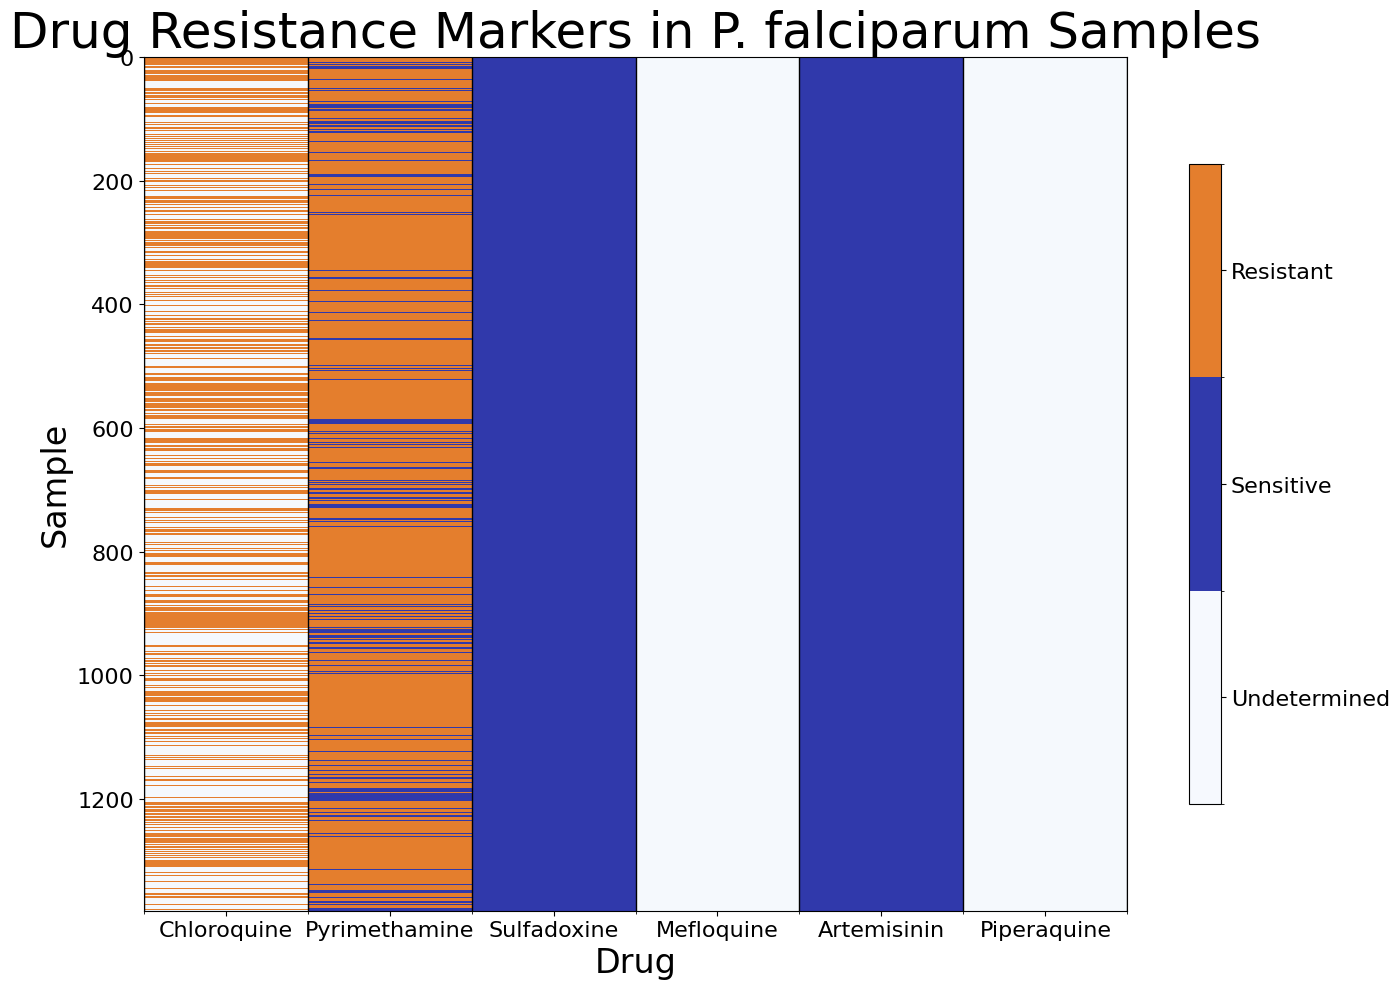

In [28]:
# Plot the resistance matrix:

import warnings

from matplotlib import colors

# Let's filter our warnings out so it looks good:
warnings.filterwarnings('ignore')

# Copy our colors from what MalariaGEN did:
cmap = colors.ListedColormap([
    [0.96470588, 0.97647059, 0.99607843],  # Undetermined
    [0.19215686, 0.22745098, 0.67058824],  # Resistant
    [0.89411765, 0.49411765, 0.17647059],  # Sensitive
])
bounds = [0.5,1.5,2.5,3.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
h = ax.imshow(resistance_matrix, cmap=cmap, norm=norm, interpolation='nearest', aspect='auto')

ax.set_title("Drug Resistance Markers in P. falciparum Samples")
ax.set_xlabel("Drug")
ax.set_ylabel("Sample")

ax.set_xticklabels(["", "Chloroquine", "Pyrimethamine", "Sulfadoxine", "Mefloquine", "Artemisinin", "Piperaquine"])

cbar = plt.colorbar(h, ticks=[1,2,3], orientation='vertical', shrink=.75)
cbar.ax.set_yticklabels(["Undetermined", "Sensitive", "Resistant"])

# # Draw gridlines
minorLocator = matplotlib.ticker.MultipleLocator(0.5)
# ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(which='minor', axis='x', linestyle='-', color=[0.0]*3, linewidth=1)

fix_plot_visuals(fig)

fig.show()

***
## Print Drug Resistance of a few samples:

In [29]:
# Print a single drug resistance:
_ = get_drug_resistance("FP0008-C", reportable_samples)

Sample	Chloroquine	Pyrimethamine	Sulfadoxine	Mefloquine	Artemisinin	Piperaquine
FP0008-C	RESISTANT	SENSITIVE	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	


In [30]:
# Print a table of drug resistances:
print("\t".join([
            "Sample\t", "Chloroquine", "Pyrimethamine", "Sulfadoxine", "Mefloquine", "Artemisinin", "Piperaquine"
        ]))
max_display = 25
for i, sample_id in enumerate(sorted(reportable_samples["entity:sample_set_id"])):
    chloroquine, pyrimethamine, sulfadoxine, mefloquine, artemisinin, piperaquine = get_drug_resistance(sample_id, reportable_samples, do_print=False)
    print(f"{sample_id}\t", end='')
    for r in [chloroquine, pyrimethamine, sulfadoxine, mefloquine, artemisinin, piperaquine]:
        print(f"{r.name}\t", end='')
    print()
    if i == max_display:
        break

Sample		Chloroquine	Pyrimethamine	Sulfadoxine	Mefloquine	Artemisinin	Piperaquine
FP0008-C	RESISTANT	SENSITIVE	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	
FP0009-C	RESISTANT	RESISTANT	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	
FP0010-CW	RESISTANT	RESISTANT	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	
FP0011-CW	RESISTANT	RESISTANT	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	
FP0012-CW	RESISTANT	RESISTANT	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	
FP0013-CW	RESISTANT	RESISTANT	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	
FP0014-CW	UNDETERMINED	RESISTANT	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	
FP0015-C	RESISTANT	RESISTANT	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	
FP0016-C	RESISTANT	SENSITIVE	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	
FP0017-C	UNDETERMINED	SENSITIVE	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	
FP0018-C	RESISTANT	RESISTANT	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMINED	
FP0019-CW	RESISTANT	RESISTANT	SENSITIVE	UNDETERMINED	SENSITIVE	UNDETERMI

In [31]:
senegal_2019_sample_df = reportable_samples[reportable_samples["dataset_provenance"] == "Broad 2019 Senegal Dataset"]

sid, rm = create_resistance_matrix(senegal_2019_sample_df)
drug_resistance_df = pd.DataFrame(rm, columns=get_drug_resistance_names())  
drug_resistance_df.insert(0, "Sample ID", sid)

Computing drug resistances:   0%|          | 0/935 [00:00<?, ?it/s]

In [32]:
def cmap_to_hex(rgb):
    return "#" + "".join([f"{(int(v * 255)):02X}" for v in rgb])

def stylize_drug_resistances(styler):
    styler.set_caption("P. falciparum Drug Resistance")
    styler.applymap(lambda r: f"background-color:{cmap_to_hex(cmap.colors[r-1])};" if type(r)==int else "background-color:white;")
    styler.format(lambda r: DrugSensitivity(r).name.upper() if type(r) == int else r)
    styler.applymap(lambda r: f"color:white;" if r==2 else "color:black;")
#     styler.hide_index()
    styler.set_properties(**{'text-align': 'center'})
    styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    return styler

print("2019 Senegal samples:")
display(drug_resistance_df.style.pipe(stylize_drug_resistances))

2019 Senegal samples:


,Sample ID,Chloroquine,Pyrimethamine,Sulfadoxine,Mefloquine,Artemisinin,Piperaquine
0,SEN-CSS-2019-001,RESISTANT,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
1,SEN-CSS-2019-002,UNDETERMINED,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
2,SEN-CSS-2019-003,UNDETERMINED,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
3,SEN-CSS-2019-004,UNDETERMINED,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
4,SEN-CSS-2019-005,UNDETERMINED,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
5,SEN-CSS-2019-007,RESISTANT,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
6,SEN-CSS-2019-009,UNDETERMINED,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
7,SEN-CSS-2019-014,RESISTANT,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
8,SEN-CSS-2019-015,UNDETERMINED,SENSITIVE,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
9,SEN-CSS-2019-016,RESISTANT,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED


In [33]:
senegal_2022_sample_df = reportable_samples[reportable_samples["dataset_provenance"] == "Broad 2022 Senegal Dataset"]

sid, rm = create_resistance_matrix(senegal_2022_sample_df)
drug_resistance_df = pd.DataFrame(rm, columns=get_drug_resistance_names())  
drug_resistance_df.insert(0, "Sample ID", sid)

print("2022 Senegal samples:")
display(drug_resistance_df.style.pipe(stylize_drug_resistances))

Computing drug resistances:   0%|          | 0/354 [00:00<?, ?it/s]

2022 Senegal samples:


,Sample ID,Chloroquine,Pyrimethamine,Sulfadoxine,Mefloquine,Artemisinin,Piperaquine
0,SEN-BAN-PP-DM1-2022-102,UNDETERMINED,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
1,SEN-BAN-PP-DM1-2022-103,RESISTANT,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
2,SEN-BAN-PP-DM1-2022-104,UNDETERMINED,SENSITIVE,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
3,SEN-BAN-PP-DM1-2022-105,RESISTANT,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
4,SEN-BAN-PP-DM1-2022-107,UNDETERMINED,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
5,SEN-BAN-PP-DM1-2022-111,UNDETERMINED,SENSITIVE,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
6,SEN-BAN-PP-DM1-2022-114,UNDETERMINED,SENSITIVE,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
7,SEN-BAN-PP-DM1-2022-116,RESISTANT,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
8,SEN-BAN-PP-DM1-2022-118,UNDETERMINED,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
9,SEN-BAN-PP-DM1-2022-120,UNDETERMINED,RESISTANT,SENSITIVE,UNDETERMINED,SENSITIVE,UNDETERMINED
